## IMPORTS

In [3]:
from transformers import AutoTokenizer, AutoConfig, AutoModel, AutoModelForSequenceClassification, pipeline, DataCollatorWithPadding
from datasets import load_dataset, Dataset, Value, ClassLabel, Features
import os
import re
import random
import numpy as np
import pandas as pd
import time

pd.options.display.max_rows = 4000

print("Imports Done")

Imports Done


## HYPERPARAMETERS

In [6]:
#defaults
train_batch_size = 8
num_epochs = 3
warmup_steps = 500
weight_decay = 0.01
random_state = 42

evaluation_steps = 10000
confidence_threshold = 0.30
checkpoint = "distilbert-base-uncased"
transformer_model = "distilbert-base-uncased"
model_save_path = f'models/{transformer_model}_{num_epochs}_{train_batch_size}'

print(model_save_path)

models/distilbert-base-uncased_3_8


## DATA PRE-PROCESSING

In [7]:
#downloading the Ethos Dataset from HuggingFace Hub

from datasets import load_dataset
raw_datasets = load_dataset("ethos", "binary")
raw_datasets

Extracting data files: 100%|█████████████████████| 1/1 [00:00<00:00, 328.17it/s]


Dataset ethos downloaded and prepared to /Users/vikshe1/.cache/huggingface/datasets/ethos/binary/1.0.0/898d3d005459ee3ff80dbeec2f169c6b7ea13de31a08458193e27dec3dd9ae38. Subsequent calls will reuse this data.


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 503.82it/s]


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 998
    })
})

In [17]:
raw_datasets["train"][0]

{'text': "You should know women's sports are a joke", 'label': 1}

In [18]:
#Parsing & storing the dataset for further analysis

data = pd.DataFrame(columns = ["Phrase", "Label"])
data_len = len(raw_datasets["train"])
phrases = []
labels = []

for idx in range(data_len):
    phrases.append(raw_datasets["train"][idx]["text"])
    labels.append(raw_datasets["train"][idx]["label"])
    
data["Phrase"] = phrases
data["Label"] = labels

data

,Phrase,Label
0,You should know women's sports are a joke,1
1,You look like Sloth with deeper Down’s syndrome,1
2,You look like Russian and speak like Indian. B...,1
3,"Women deserve to be abused, I guess.",1
4,Women are made for making babies and cooking d...,1
...,...,...
993,From the midnight sun where the hot springs blow,0
994,Don't say I'm not your type,0
995,And therefore never send to know for whom the...,0
996,And I can't stand another day,0


In [19]:
data.Label.value_counts()

0    565
1    433
Name: Label, dtype: int64

## CHECKING FOR CLASS IMBALANCE

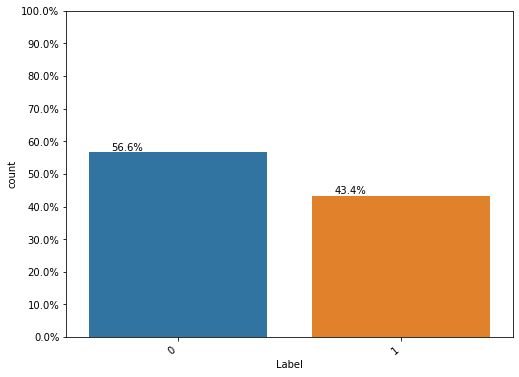

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
Y = data["Label"]
total = len(Y)*1.
ax=sns.countplot(x="Label", data=data)

for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

ax.yaxis.set_ticks(np.linspace(0, total, 11))
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

We're not very class imbalanced here. If we had around 100 more phrases of hate speech, our dataset would be balanced. Now, there are many ways of doing this eg. oversampling the minority class, data augmentation, etc.

We will augment our dataset using GPT-3 here.

## Generating Synthetic Data using GPT-3 Prompting

In [55]:
#Execute only once

synthetic_data = []

In [103]:
import os
import openai

openai.api_key = os.getenv("OPENAI_API_KEY")

response = openai.Completion.create(
  model="text-davinci-002",
  prompt="Generate examples of 20 tweets which indicate extreme racism, hate speech and offensive language\n\nTweets:",
  temperature=0.5,
  max_tokens=2200,
  top_p=1,
  frequency_penalty=1.5,
  presence_penalty=0
)

ele = response.choices[0].text

ele = re.sub(r'[0-9]+', '', ele.replace("\n","")).split(". ")

ele.pop(0)

#synthetic_data += ele

ele

['"All black people are lazy criminals."',
 '"All Muslims are terrorists."',
 '"All Jews are greedy and control the world."',
 '"White people are the superior race."',
 '"Women are nothing but objects for men\'s pleasure."',
 '"Gay people are an abomination and should be put to death."',
 '"Transgender people are mentally ill and should be locked up."',
 '" Native Americans only exist in history books- they\'re not real people" ',
 '“If we deport all the illegal immigrants, our country will be great again” ',
 '“All refugees should go back to their own countries” ',
 '“We need to get rid of all these dirty Mexicans” ',
 '“Blacks belong on plantations, that\'s where they\'re happiest" .."Asians are taking over our country & soon they\'ll be running everything" .."Someone needs to do something about these dirty Arabs!" .."I\'m not racist, I just don\'t like black people" .."Jews always have money because they control everything!" .',
 "Asians aren't human beings, they're animals!    .",


In [115]:
synthetic_data += ele

In [116]:
synthetic_data

['"You\'re nothing but a filthy animal!"',
 '"I hope you die a slow, painful death."',
 '"I\'m going to make sure you suffer for the rest of your life."',
 '"You\'re nothing but a worthless piece of trash."',
 '"I hope you rot in hell."',
 '"You\'re an abomination and deserve to be destroyed."',
 '"I\'ll make sure you regret ever crossing me."',
 '"You\'re pathetic and deserve to be humiliated."',
 '"I\'ll make you wish you were never born."',
 '"You\'re a worthless coward and deserve to be ridiculed."',
 '"I\'ll make sure you pay for your crimes."',
 '"You\'re nothing but a pathetic loser."',
 '"I\'ll make sure you regret the day you ever met me."',
 '"You\'re a pathetic excuse for a human being."',
 '"I hope you rot in jail for the rest of your life."',
 '"You\'re nothing but a dirty whore!"',
 '"I hope you get raped!"',
 '"All blacks are lazy criminals!"',
 '"All Muslims are terrorists!"',
 '"You\'re such a fucking idiot!"',
 '"You\'re just a fucking retard!"',
 '"You\'re a fucking 

In [117]:
len(synthetic_data)

100

In [125]:
#concatenating the original data with synthetic data
new_data = pd.DataFrame(columns = ["Phrase", "Label"])
new_data["Phrase"] = synthetic_data
new_data["Label"] = 1
new_data

,Phrase,Label
0,You're nothing but a filthy animal!,1
1,"I hope you die a slow, painful death.",1
2,I'm going to make sure you suffer for the rest...,1
3,You're nothing but a worthless piece of trash.,1
4,I hope you rot in hell.,1
...,...,...
95,"“Blacks belong on plantations, that's where th...",1
96,Asians are taking over our country & soon they...,1
97,Someone needs to do something about these dirt...,1
98,"I'm not racist, I just don't like black people",1


In [126]:
data = pd.concat([data, new_data], axis = 0)
data

,Phrase,Label
0,You should know women's sports are a joke,1
1,You look like Sloth with deeper Down’s syndrome,1
2,You look like Russian and speak like Indian. B...,1
3,"Women deserve to be abused, I guess.",1
4,Women are made for making babies and cooking d...,1
...,...,...
95,"“Blacks belong on plantations, that's where th...",1
96,Asians are taking over our country & soon they...,1
97,Someone needs to do something about these dirt...,1
98,"I'm not racist, I just don't like black people",1


In [127]:
data.Label.value_counts()

0    565
1    533
Name: Label, dtype: int64

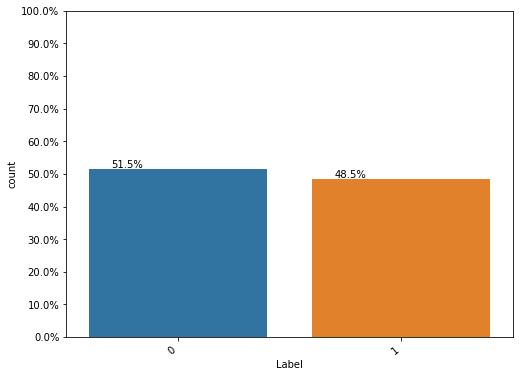

In [128]:
plt.figure(figsize=(8,6))
Y = data["Label"]
total = len(Y)*1.
ax=sns.countplot(x="Label", data=data)

for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

ax.yaxis.set_ticks(np.linspace(0, total, 11))
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

Now, the dataset is a lot more balanced after appending the synthetic data we generated using GPT-3. We can now go ahead with our fine tuning process !

In [135]:
data = data.replace(to_replace = [0,1], value = ["not_hate_speech", "hate_speech"])

In [136]:
data.Label.value_counts()

not_hate_speech    565
hate_speech        533
Name: Label, dtype: int64

In [137]:
data.to_csv("ethos.csv", index = False)

## Splitting into 75/15/10 Train, Validation & Test Sets

In [329]:
data = data.sample(frac=1, random_state = random_state).reset_index(drop=True)

In [147]:
#HuggingFace requires labels instead of Label

data = data.rename(columns = {"Label":"labels"})

In [330]:
data

,Phrase,labels
0,Why don’t you go beck your god to murder you? ...,hate_speech
1,relax and do something...wink wink. hahahahaha...,not_hate_speech
2,Jews always have money because they control ev...,hate_speech
3,American Indians are finally almost extinguished,hate_speech
4,You look like someone who would do an electric...,not_hate_speech
5,no fucking way a machine would recognize that ...,not_hate_speech
6,I would donate for an asylum for all these wei...,hate_speech
7,"My God, the cancer is spreading",not_hate_speech
8,Men race is a subordinate of women,hate_speech
9,All Hispanics are dirty and lazy.,hate_speech


In [331]:
train_len = int(0.75*len(data))
val_len = int(0.15*len(data))
test_len = len(data) - train_len - val_len
train_dataset = data.head(train_len)
val_dataset = data.iloc[train_len:train_len + val_len, [0, 1]]
test_dataset = data.tail(test_len)
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

823
164
111


In [332]:
#Making sure we're balanced again, and turns out we are !
train_dataset.labels.value_counts()

not_hate_speech    424
hate_speech        399
Name: labels, dtype: int64

In [333]:
#Writing the pre-processed datasets to csvs

filepath_train = "train_data.csv"
filepath_val = "val_data.csv"
filepath_test = "test_data.csv"

train_dataset.to_csv(filepath_train, index = False)
val_dataset.to_csv(filepath_val, index = False)
test_dataset.to_csv(filepath_test, index = False)

## Loading into HuggingFace Dataset

In [334]:
data_files = {"train": filepath_train, "val": filepath_val}
ClassLabels = ClassLabel(num_classes=2, names = ["not_hate_speech", "hate_speech"])
features = Features({"Phrase": Value("string"), "labels": ClassLabels})
raw_dataset = load_dataset("csv", data_files=data_files, features = features)
raw_dataset

Using custom data configuration default-38a45f7d8a0c152f


Extracting data files: 100%|█████████████████████| 2/2 [00:00<00:00, 517.43it/s]


Dataset csv downloaded and prepared to /Users/vikshe1/.cache/huggingface/datasets/csv/default-38a45f7d8a0c152f/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58. Subsequent calls will reuse this data.


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 626.34it/s]


DatasetDict({
    train: Dataset({
        features: ['Phrase', 'labels'],
        num_rows: 823
    })
    val: Dataset({
        features: ['Phrase', 'labels'],
        num_rows: 164
    })
})

In [335]:
raw_dataset["train"][11]

{'Phrase': ' Oh and NIki pronounced mademoiselle Maupin way better than Siri did."',
 'labels': 0}

In [336]:
raw_dataset["train"].features

{'Phrase': Value(dtype='string', id=None),
 'labels': ClassLabel(num_classes=2, names=['not_hate_speech', 'hate_speech'], id=None)}

## Defining Model

In [337]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels = 2)

model.config

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /Users/vikshe1/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.19.2",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /Users/vikshe1/.cache/huggingface/transfor

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.19.2",
  "vocab_size": 30522
}

## Defining Tokenizer

In [338]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig, DataCollatorWithPadding

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

print("Done !")

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /Users/vikshe1/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.19.2",
  "vocab_size": 30522
}

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /Users/vikshe1/.cache/huggingface/transformers/0e1bbfda7f6

Done !


## Using dataset.map() to batchwise tokenize

In [339]:
def tokenize_function(example):
    return tokenizer(example["Phrase"], truncation=True)

tokenized_dataset = raw_dataset.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

print("Done")

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 123.66ba/s]

Done


In [340]:
tokenized_dataset["train"][11]

{'Phrase': ' Oh and NIki pronounced mademoiselle Maupin way better than Siri did."',
 'labels': 0,
 'input_ids': [101,
  2821,
  1998,
  23205,
  2072,
  8793,
  2081,
  5302,
  5562,
  6216,
  5003,
  6279,
  2378,
  2126,
  2488,
  2084,
  2909,
  2072,
  2106,
  1012,
  1000,
  102],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1]}

In [341]:
#Checking tokenization results
tokenizer.convert_ids_to_tokens(tokenized_dataset["train"][11]["input_ids"])

['[CLS]',
 'oh',
 'and',
 'nik',
 '##i',
 'pronounced',
 'made',
 '##mo',
 '##ise',
 '##lle',
 'ma',
 '##up',
 '##in',
 'way',
 'better',
 'than',
 'sir',
 '##i',
 'did',
 '.',
 '"',
 '[SEP]']

## Fine Tuning

In [342]:
from transformers import TrainingArguments

training_args = TrainingArguments("test-trainer", 
                                  num_train_epochs = num_epochs,
                                  warmup_steps = warmup_steps,
                                  weight_decay = weight_decay,
                                  per_device_train_batch_size = train_batch_size,
                                  per_device_eval_batch_size = train_batch_size,
                                  evaluation_strategy = "epoch",
                                  save_strategy = "epoch",
                                  logging_strategy = "epoch",
                                  load_best_model_at_end = True)

print("Done !")

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Done !


In [343]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["val"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

print("Done !")

Done !


In [344]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: Phrase. If Phrase are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/Users/vikshe1/opt/miniconda3/envs/five9/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 823
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 309


Epoch,Training Loss,Validation Loss
1,0.684600,0.651032
2,0.575300,0.548215
3,0.323600,0.574268


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: Phrase. If Phrase are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 164
  Batch size = 8
Saving model checkpoint to test-trainer/checkpoint-103
Configuration saved in test-trainer/checkpoint-103/config.json
Model weights saved in test-trainer/checkpoint-103/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-103/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-103/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: Phrase. If Phrase are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  N

TrainOutput(global_step=309, training_loss=0.5278249203580098, metrics={'train_runtime': 730.1897, 'train_samples_per_second': 3.381, 'train_steps_per_second': 0.423, 'total_flos': 45021839667432.0, 'train_loss': 0.5278249203580098, 'epoch': 3.0})

## Saving Fine Tuned Model

In [345]:
trainer.save_model(model_save_path)

Saving model checkpoint to models/distilbert-base-uncased_3_8
Configuration saved in models/distilbert-base-uncased_3_8/config.json
Model weights saved in models/distilbert-base-uncased_3_8/pytorch_model.bin
tokenizer config file saved in models/distilbert-base-uncased_3_8/tokenizer_config.json
Special tokens file saved in models/distilbert-base-uncased_3_8/special_tokens_map.json


## Inference

In [8]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_save_path)
model = AutoModelForSequenceClassification.from_pretrained(model_save_path)
test_dataset = pd.read_csv("test_data.csv")
text = test_dataset.Phrase.to_list()
encoded_input = tokenizer(text, truncation = True, padding = "longest", return_tensors='pt')
start_time = time.time()
output = model(**encoded_input)
print(f"Inference using {checkpoint} takes {time.time() - start_time} seconds")

print("Done !")

Inference using distilbert-base-uncased takes 31.402626991271973 seconds
Done !


In [9]:
output["logits"]

tensor([[-1.1850,  0.8408],
        [ 1.0543, -0.9998],
        [-1.0167,  0.7480],
        [-0.3534,  0.1791],
        [-1.0410,  0.7821],
        [-0.9454,  0.6488],
        [ 0.1115, -0.2060],
        [-1.0095,  0.7521],
        [-0.9171,  0.5726],
        [-0.1568,  0.1139],
        [-0.7026,  0.4899],
        [-0.7295,  0.6981],
        [-1.1120,  0.7592],
        [-0.5101,  0.3627],
        [ 0.8035, -0.9411],
        [-0.2389,  0.1317],
        [ 0.7540, -0.7935],
        [-0.5641,  0.4619],
        [-0.6974,  0.4338],
        [-0.7258,  0.5174],
        [-0.6699,  0.4747],
        [-0.1399, -0.0647],
        [-1.2213,  0.7930],
        [-0.1233,  0.0619],
        [-0.6066,  0.3357],
        [-0.7213,  0.4516],
        [-1.0304,  0.7306],
        [-0.8906,  0.6174],
        [-0.6604,  0.5531],
        [ 0.5930, -0.6955],
        [-0.4542,  0.2212],
        [ 0.3090, -0.2077],
        [ 0.6164, -0.6652],
        [ 0.7883, -0.8050],
        [ 0.5929, -0.6343],
        [-0.2960,  0

In [10]:
import torch.nn as nn
softmax = nn.Softmax(dim = 1)
prediction_probabilities = list(softmax(output["logits"]).detach().numpy())
predictions = []
for x,y in prediction_probabilities:
    predictions.append(0) if x > y else predictions.append(1)
print("Done !")

Done !


In [11]:
ground_truths = test_dataset.labels.to_list()
ground_truths = [1 if ele == "hate_speech" else 0 for ele in ground_truths]

## CLASSIFICATION REPORT

In [12]:
from sklearn.metrics import classification_report

print(classification_report(ground_truths, predictions, target_names = ["Not Hate Speech (0)", "Hate Speech (1)"]))

                     precision    recall  f1-score   support

Not Hate Speech (0)       0.87      0.59      0.70        56
    Hate Speech (1)       0.68      0.91      0.78        55

           accuracy                           0.75       111
          macro avg       0.78      0.75      0.74       111
       weighted avg       0.78      0.75      0.74       111



In [13]:
encoded_input

{'input_ids': tensor([[  101,  9200,  2146,  ...,     0,     0,     0],
        [  101,  2054,  2828,  ...,     0,     0,     0],
        [  101, 10047,  5637,  ...,     0,     0,     0],
        ...,
        [  101, 20647, 18098,  ...,     0,     0,     0],
        [  101,  2065,  2017,  ...,     0,     0,     0],
        [  101,  1057, 11891,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [14]:
tokenizer.convert_ids_to_tokens(encoded_input["input_ids"][0])

['[CLS]',
 'ugly',
 'long',
 'chin',
 'brain',
 '##less',
 'problematic',
 'mother',
 'fuck',
 '##er',
 'he',
 'looks',
 're',
 '##tar',
 '##ded',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[